Capstone Two: Exploratory Data Analysis

The main goal is to determine correlations and predictors for max stretch force and unitized pull force.

In [2]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib .pyplot as plt 
import seaborn as sns 
from scipy.stats import pearsonr
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot #
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from sklearn.cluster import DBSCAN
import warnings #
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
df = pd.read_parquet('../data/cleaned_data.parquet')

In [4]:
df.dtypes

alloy                           object
job                             object
lot                             object
piece                           object
gauge                          float64
width                          float64
length                         float64
delay                          float64
prestretch_force                 int64
stretch_target                 float64
stretch_actual                 float64
max_force                        int64
step_duration          timedelta64[ns]
pre_stretch_length             float64
post_stretch_length            float64
yield_point                      int64
discharge               datetime64[ns]
step_start_datetime     datetime64[ns]
key                             object
unitized_PF                    float64
dtype: object

In [5]:
df.head()

alloy      job       lot piece  gauge  width  length  delay  \
0  XR7AT0K50  3179890  622597A3     1  3.988  56.25  355.76    8.2   
1  XR7AT0K50  3162736  624670A6     1  3.988  56.25  358.05   12.3   
2  XR7AT0K50  3115404  627722A2     1  3.844  56.50  343.00    5.0   
3  XR7AT0K50  3136864  627717A2     1  3.844  56.50  344.17    9.2   
4  XR7AT0K50  3162724  624750A6     1  3.988  56.01  354.97    6.6   

   prestretch_force  stretch_target  stretch_actual  max_force  \
0           6476512             2.0        2.178052    8449903   
1           6476512             2.0        2.187799    8686119   
2           6242656             2.0        2.176928    8286410   
3           6242656             2.0        2.177896    8291038   
4           6476512             2.0        2.141514    8813926   

           step_duration  pre_stretch_length  post_stretch_length  \
0        0 days 00:00:07            353.6535             361.3563   
1 0 days 00:00:07.010000            355.9468             363.7343   
2 0 days 00:00:15.720000            341.5384             348.9734   
3 0 days 00:00:15.630000            342.2903             349.7451   
4 0 days 00:00:13.810000            353.4370             361.0059   

   yield_point           discharge step_start_datetime  \
0      6476512 2013-01-01 00:18:57 2013-01-01 00:17:16   
1      6476512 2013-01-01 00:23:03 2013-01-01 00:21:19   
2      6242656 2013-01-01 00:27:42 2013-01-01 00:26:00   
3      6242656 2013-01-01 00:31:53 2013-01-01 00:30:11   
4      6476512 2013-01-01 00:56:20 2013-01-01 00:54:38   

                                         key  unitized_PF  
0  2013-01-01-12:18:57 AM-3179890-622597A3-1   150.220498  
1  2013-01-01-12:23:03 AM-3162736-624670A6-1   154.419893  
2  2013-01-01-12:27:42 AM-3115404-627722A2-1   146.662124  
3  2013-01-01-12:31:53 AM-3136864-627717A2-1   146.744035  
4  2013-01-01-12:56:20 AM-3162724-624750A6-1   157.363435

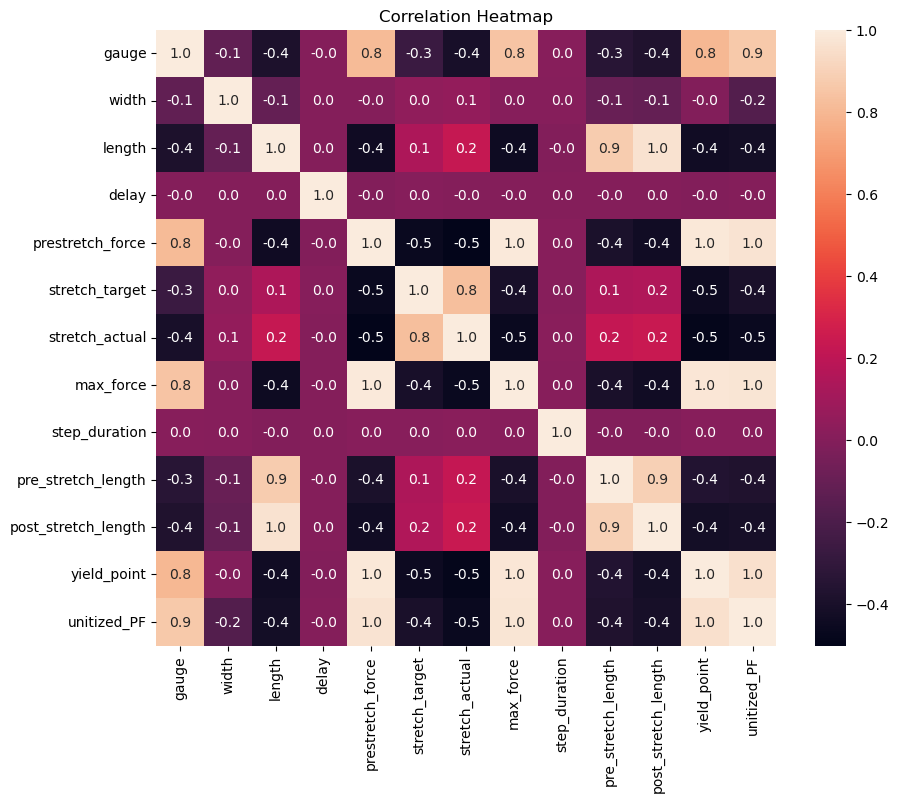

In [6]:
# Compute correlation with numeric columns
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f')
plt.title('Correlation Heatmap')
plt.show()

In [7]:
max_force_corr = abs(correlation_matrix['max_force']).sort_values(ascending=False)
max_force_corr

max_force              1.000000
prestretch_force       0.991866
yield_point            0.981057
unitized_PF            0.976310
gauge                  0.842986
stretch_actual         0.462997
length                 0.448444
post_stretch_length    0.436030
stretch_target         0.405404
pre_stretch_length     0.397676
step_duration          0.012571
width                  0.006477
delay                  0.002627
Name: max_force, dtype: float64

max_force prediction is the goal. top correlations of interest to predict max_force have to be features known prior to the pull of plate: gauge, stretch_target, length

In [9]:
predictors = ['gauge', 'stretch_target', 'length']

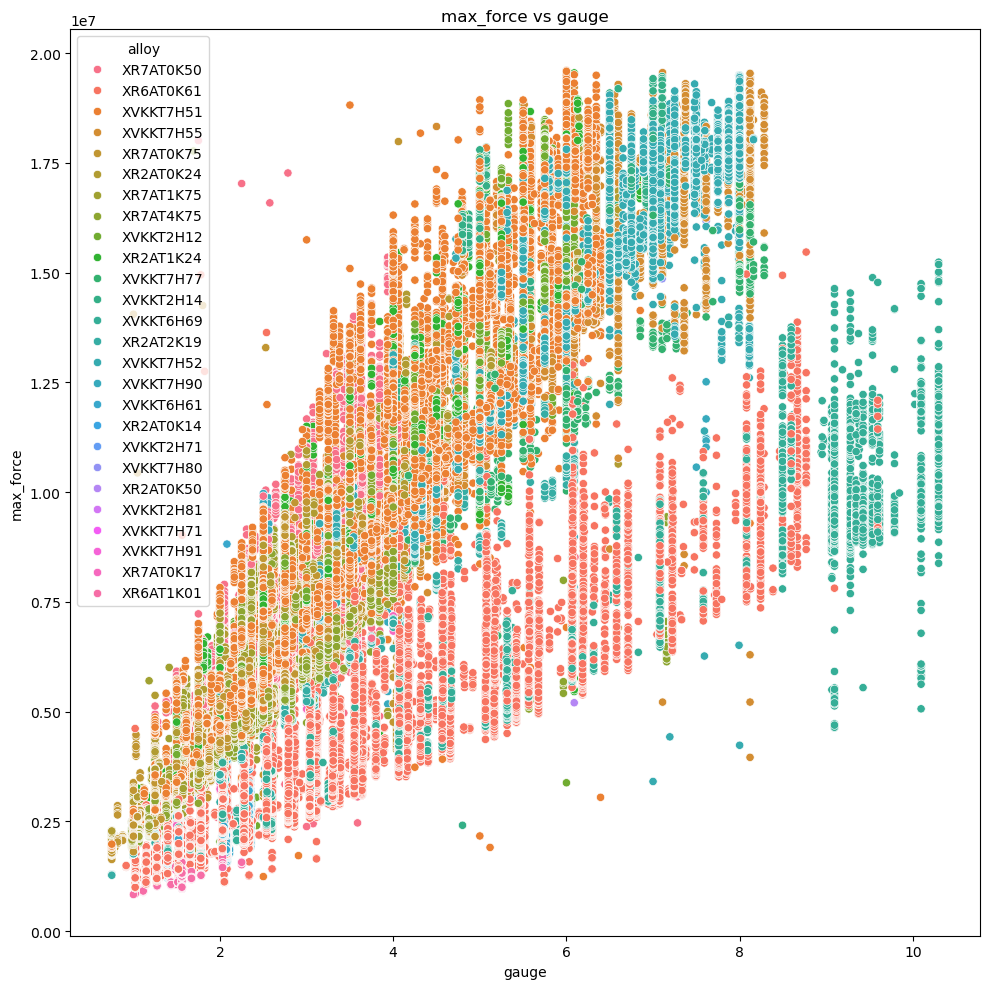

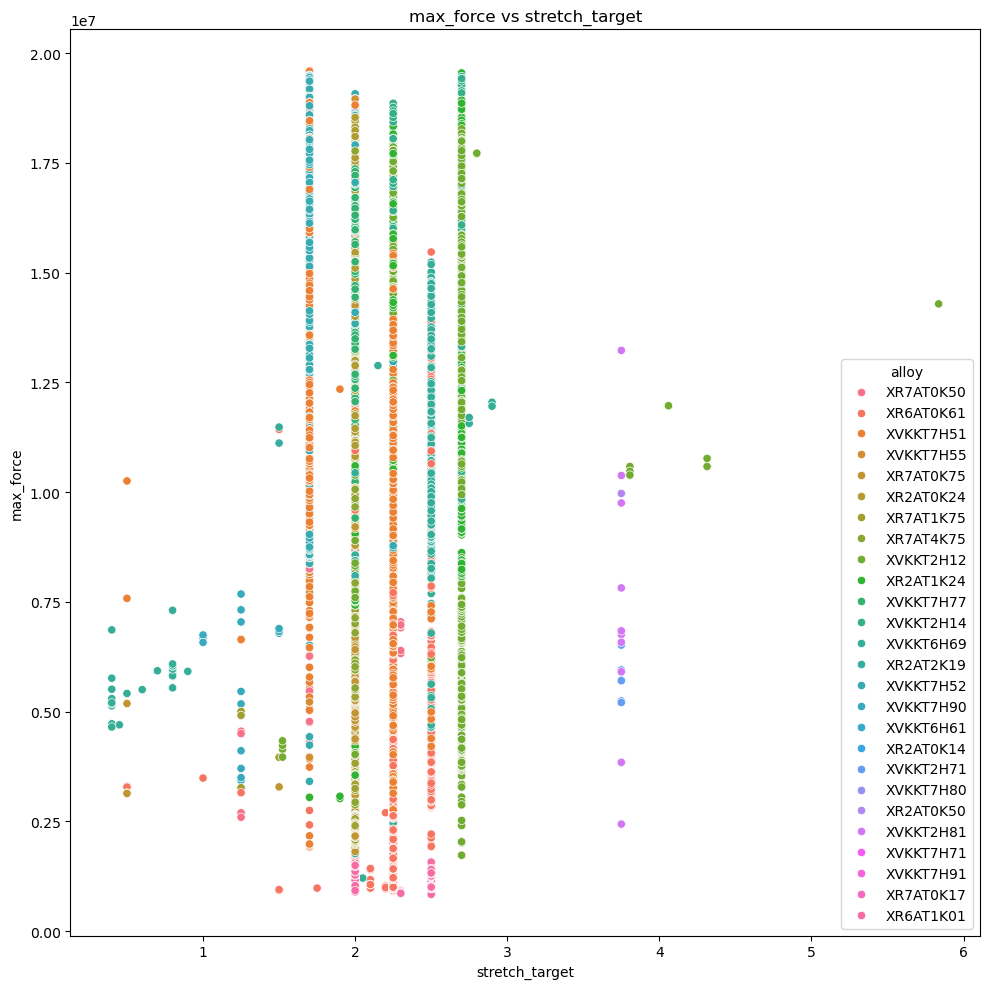

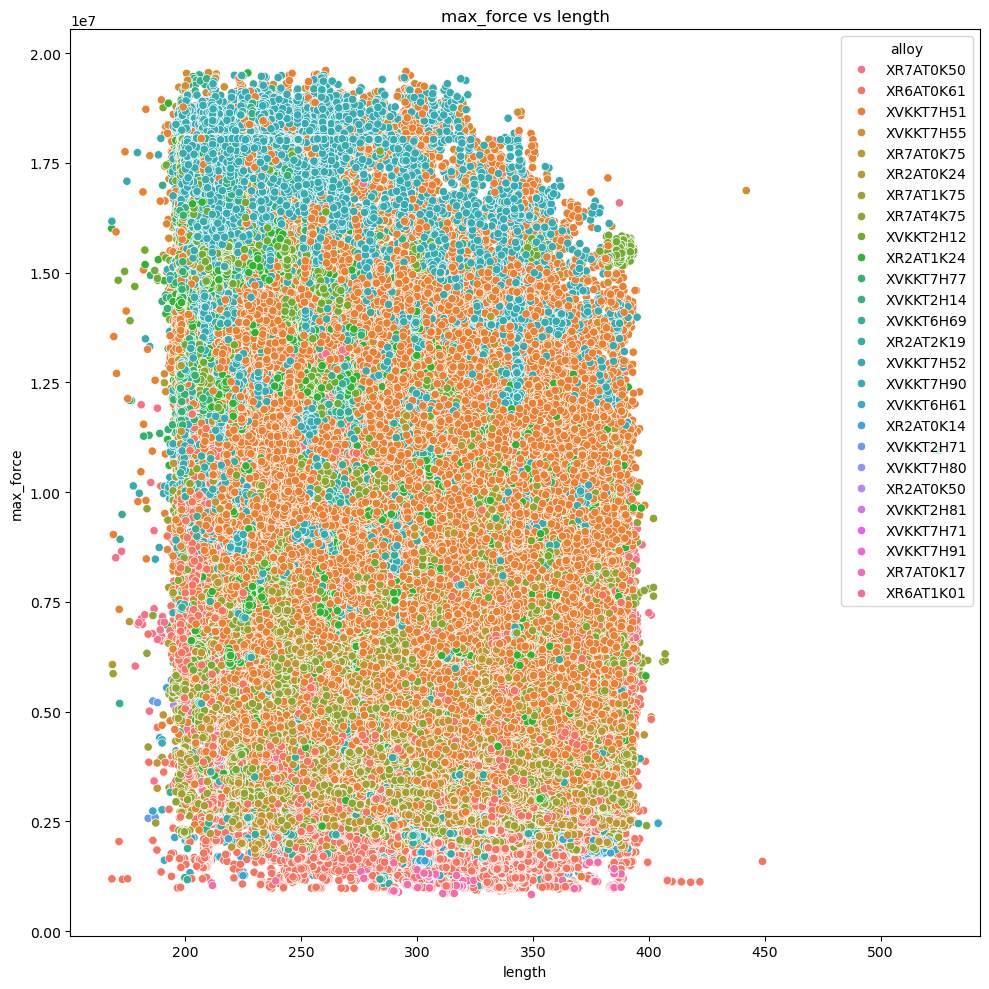

In [10]:
target = 'max_force'
features = ['gauge', 'stretch_target', 'length']

for feature in features:
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=df[feature], y=df[target], hue='alloy', data=df)
    plt.title(f'{target} vs {feature}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

In [11]:
for i in predictors:
    r, p = pearsonr(df[i], df['max_force'])
    print(f"{i} r = {r:.2f}, p = {p:.4f}")

gauge r = 0.84, p = 0.0000
stretch_target r = -0.41, p = 0.0000
length r = -0.45, p = 0.0000


Predictors have p<=0.05, therefore, show significance. 

Examine alloy and discharge date/time

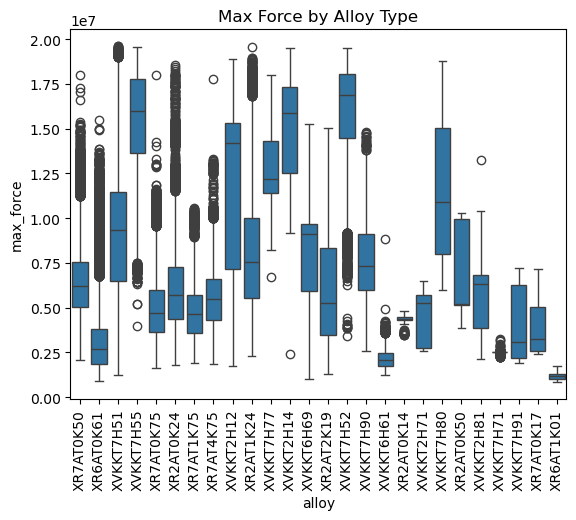

In [14]:
sns.boxplot(data=df, x='alloy', y='max_force')
plt.title('Max Force by Alloy Type')
plt.xticks(rotation=90)
plt.show()

Some alloys have a large section of outliers.

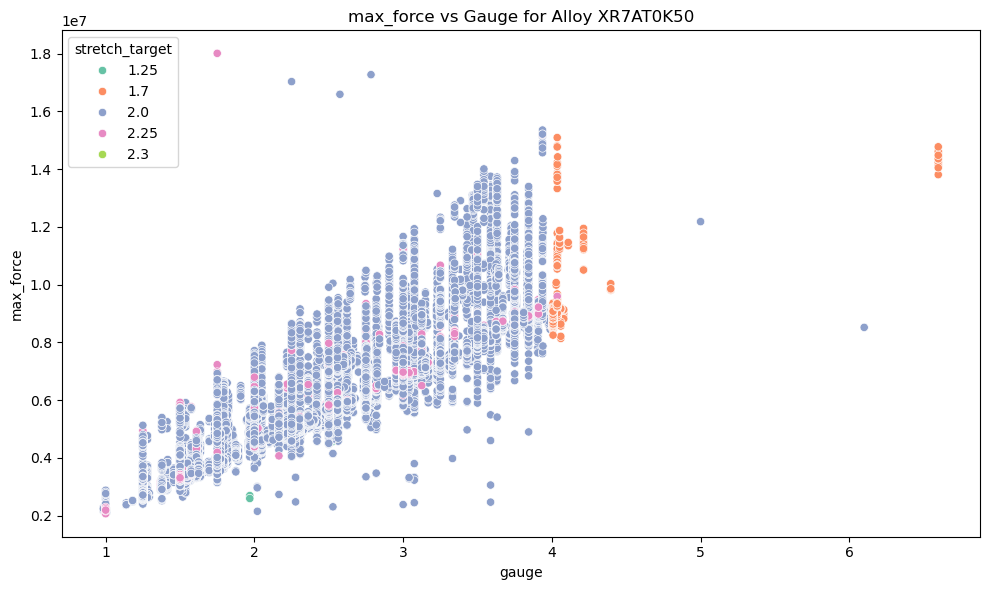

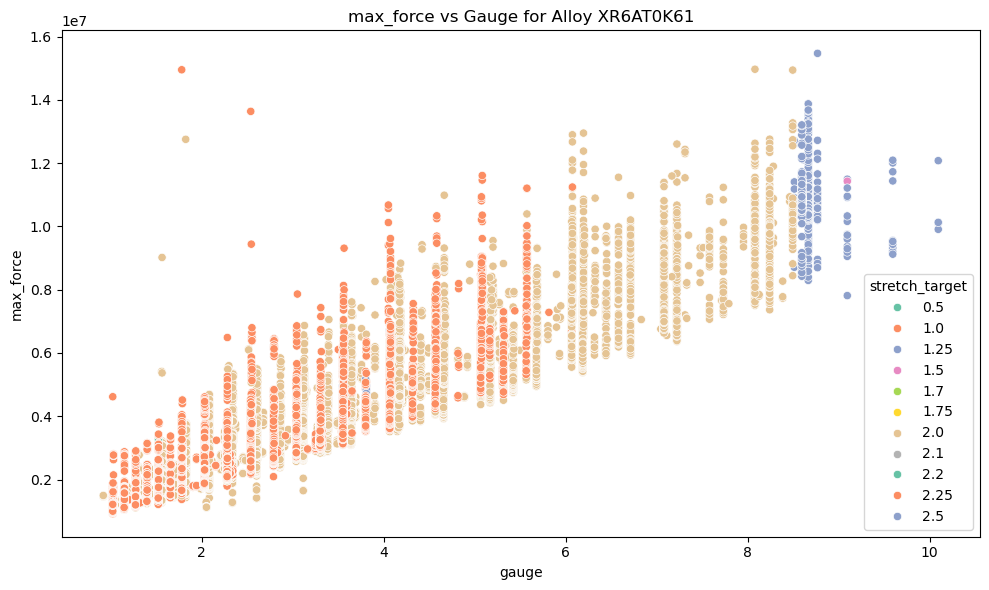

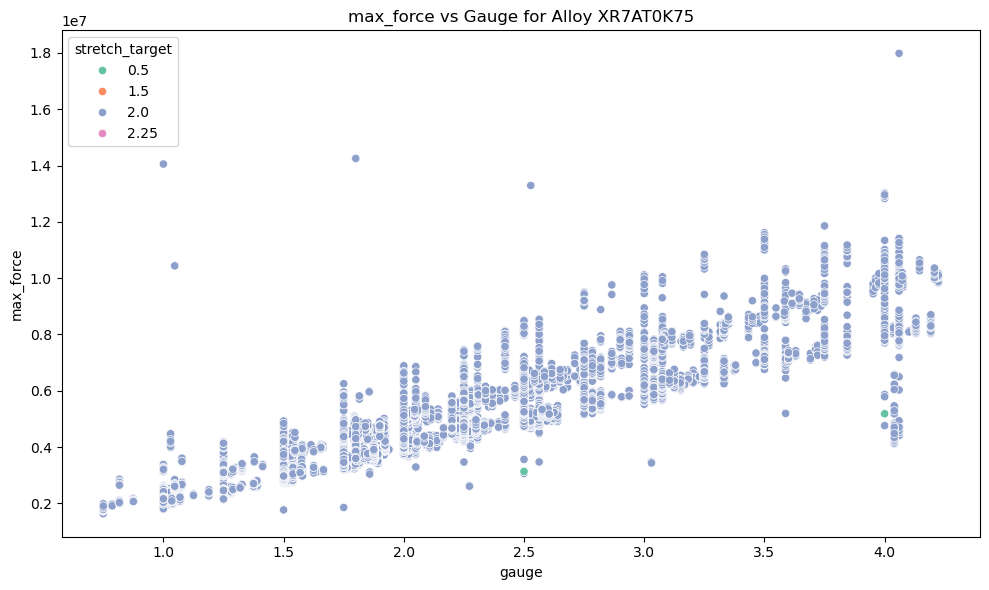

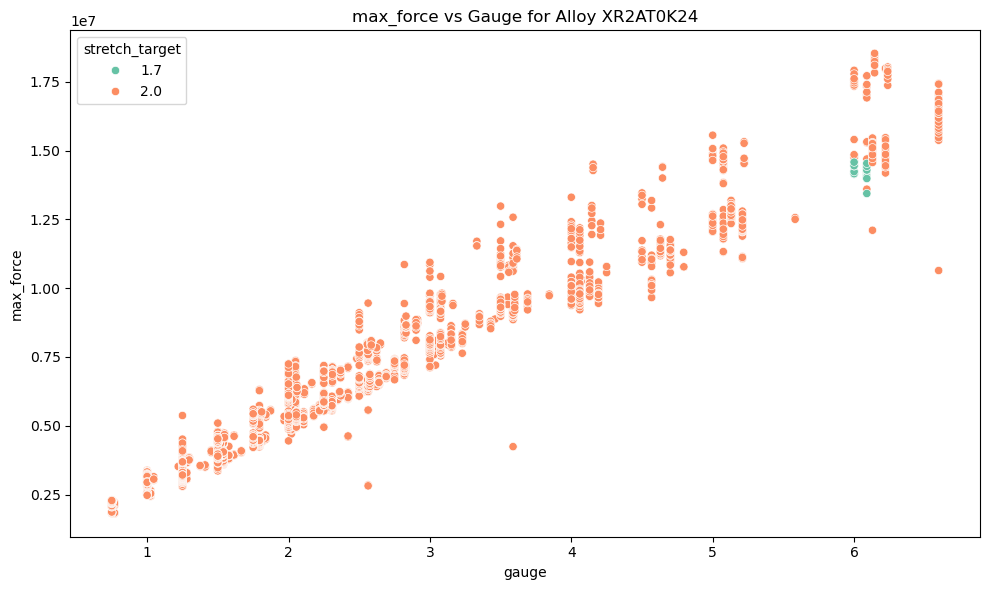

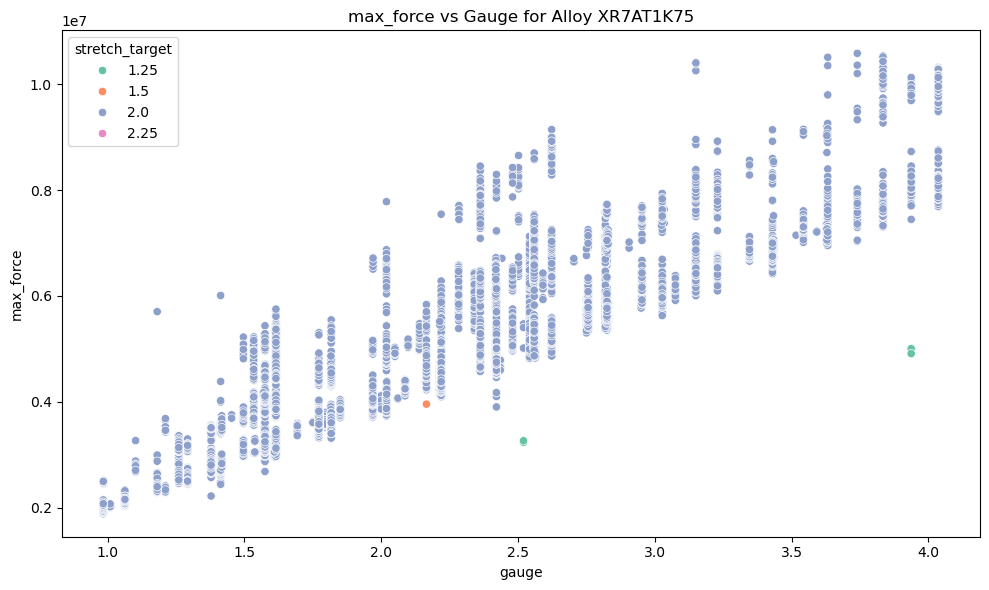

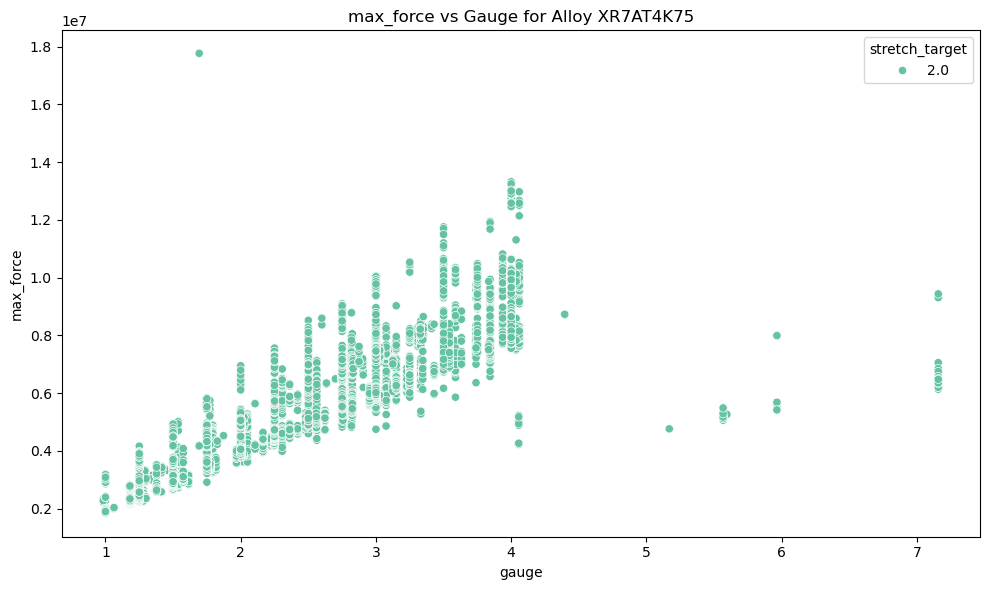

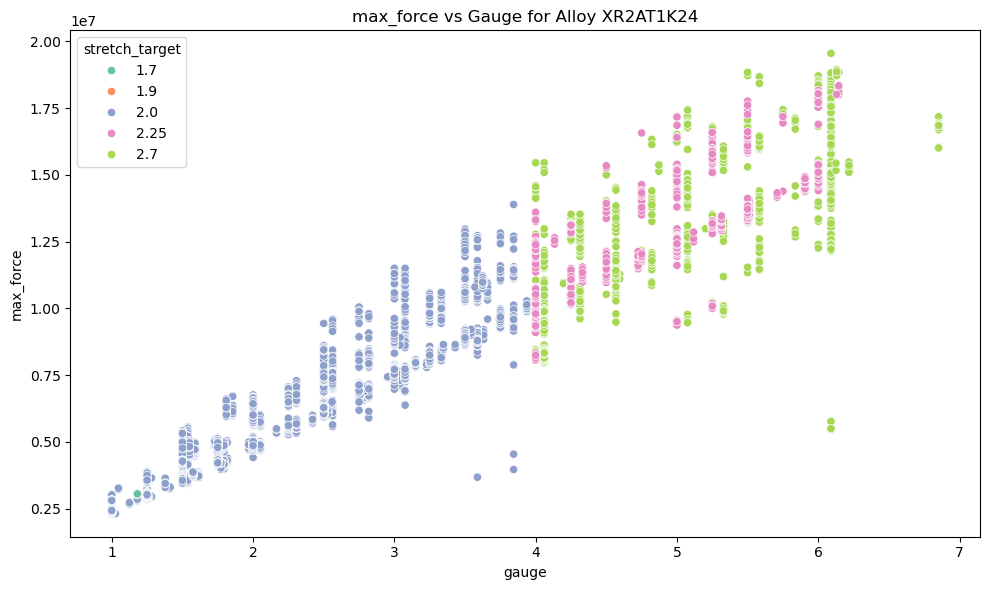

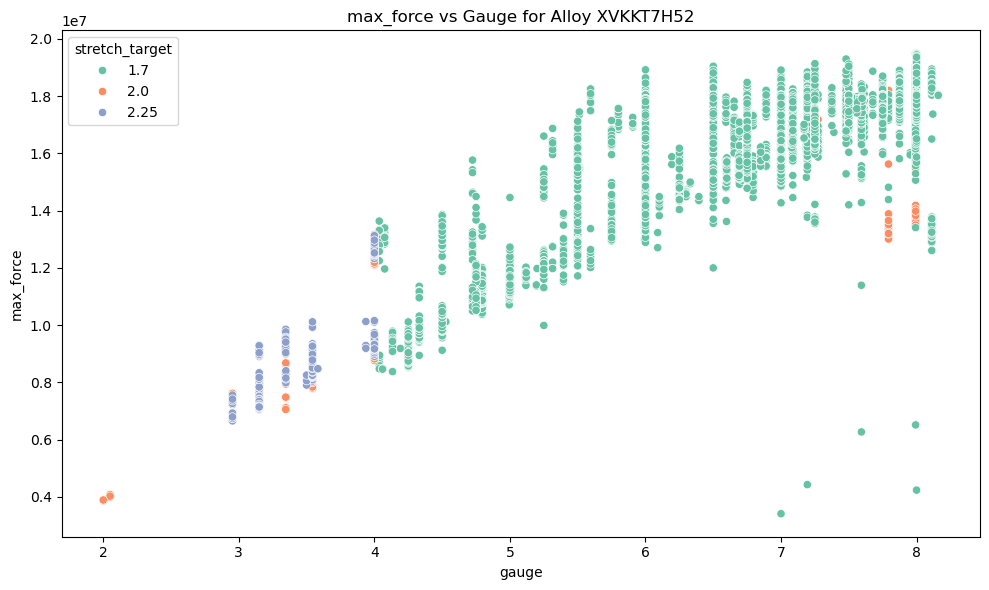

In [40]:
target = 'max_force'
alloy_names = ['XR7AT0K50', 'XR6AT0K61', 'XR7AT0K75', 'XR2AT0K24', 'XR7AT1K75', 'XR7AT4K75', 'XR2AT1K24', 'XVKKT7H52']

for alloy in alloy_names:
    subset = df[df['alloy'] == alloy]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='gauge', y=target, hue='stretch_target', data=subset, palette='Set2')
    plt.title(f'{target} vs Gauge for Alloy {alloy}')
    plt.xlabel('gauge')
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

In [17]:
stretch_counts = df.groupby(['alloy', 'stretch_target']).size().unstack(fill_value=0)
stretch_counts.loc[:, stretch_counts.sum(axis=0) >= 40]

stretch_target   1.70    2.00   2.25  2.50  2.70
alloy                                           
XR2AT0K14           0     186      0     0     0
XR2AT0K24          29    9571      0     0     0
XR2AT0K50           0       3      0     0     0
XR2AT1K24           2   10624   1219     0  2504
XR2AT2K19           0    3627      0     0     0
XR6AT0K61           2   44533  38049  1245     0
XR6AT1K01           0     115      0   192     0
XR7AT0K17           0      20      0     0     0
XR7AT0K50         884  123594   4560     0     0
XR7AT0K75           0   47390      6     0     0
XR7AT1K75           0   23300      1     0     0
XR7AT4K75           0   13437      0     0     0
XVKKT2H12           0    2075   1866     4  3815
XVKKT2H14           0       0    340     0   825
XVKKT2H71           0       3      0     0     0
XVKKT2H81           0       7      0     0     0
XVKKT6H61           0    5165   1389     0     0
XVKKT6H69           0    1914   1439  5185     0
XVKKT7H51       46728   14315  39535    12     0
XVKKT7H52       14928     713    516     0     0
XVKKT7H55       15840     730      0     0     0
XVKKT7H71           0     807      0     0     0
XVKKT7H77           0    2184      0     0     0
XVKKT7H80           0     124      0     0     0
XVKKT7H90           0     591      0     0     0
XVKKT7H91           0      64      0     0     0

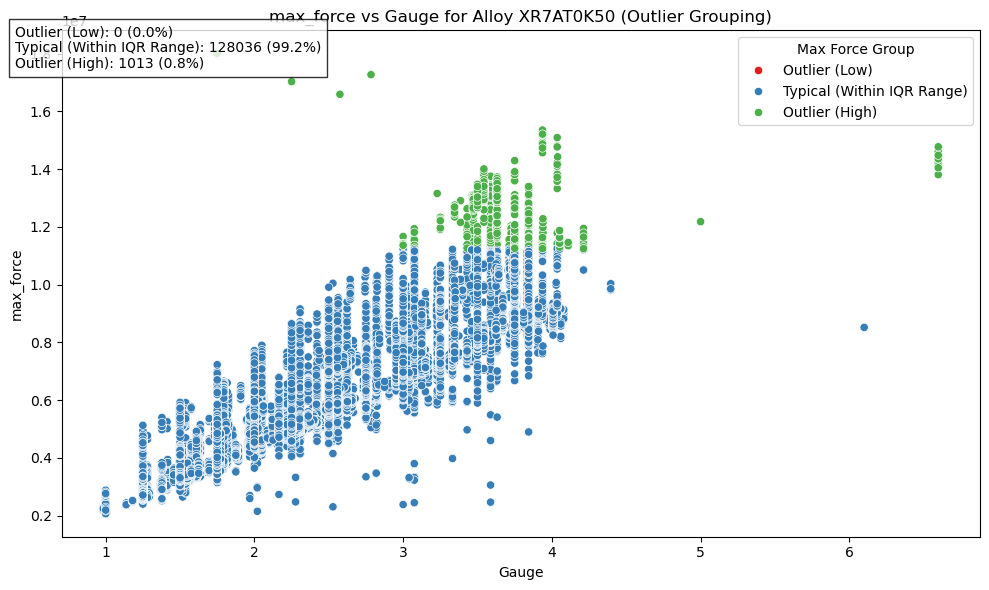

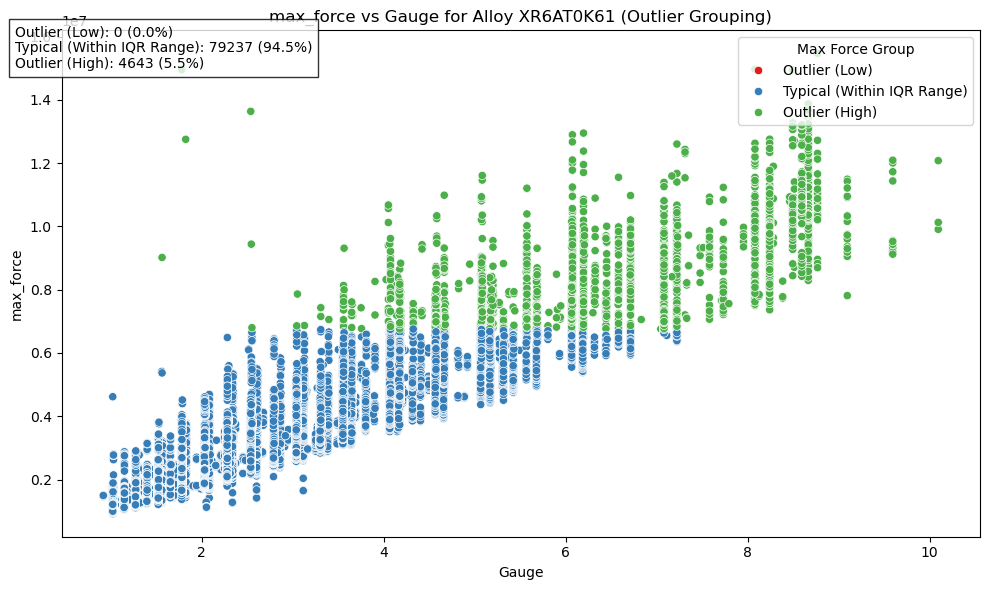

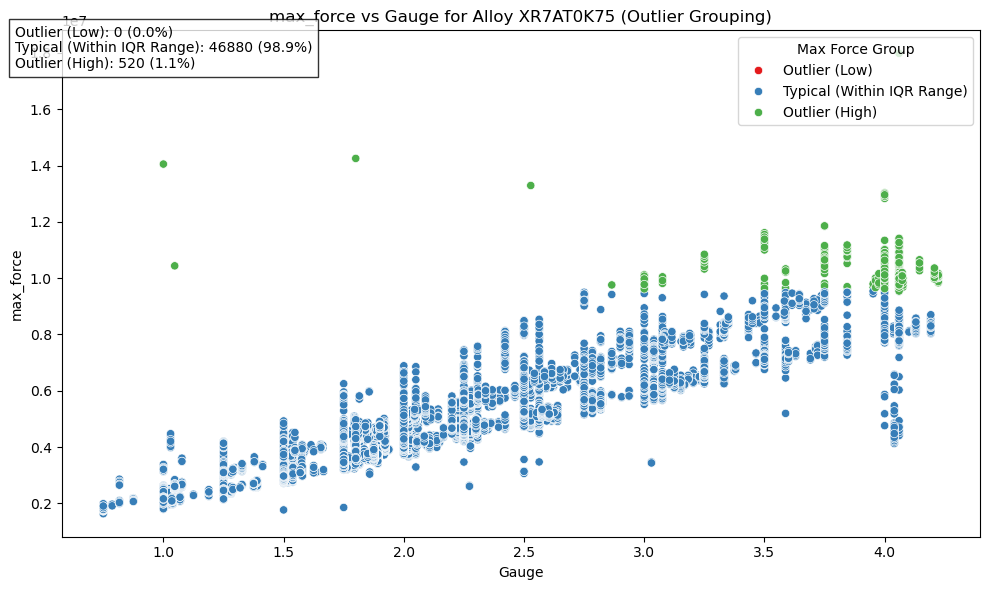

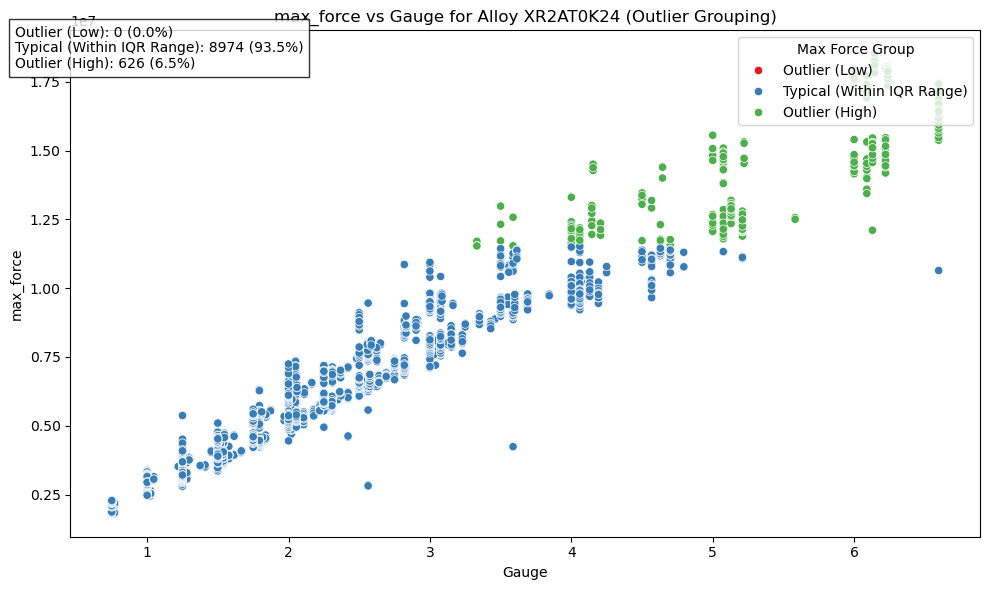

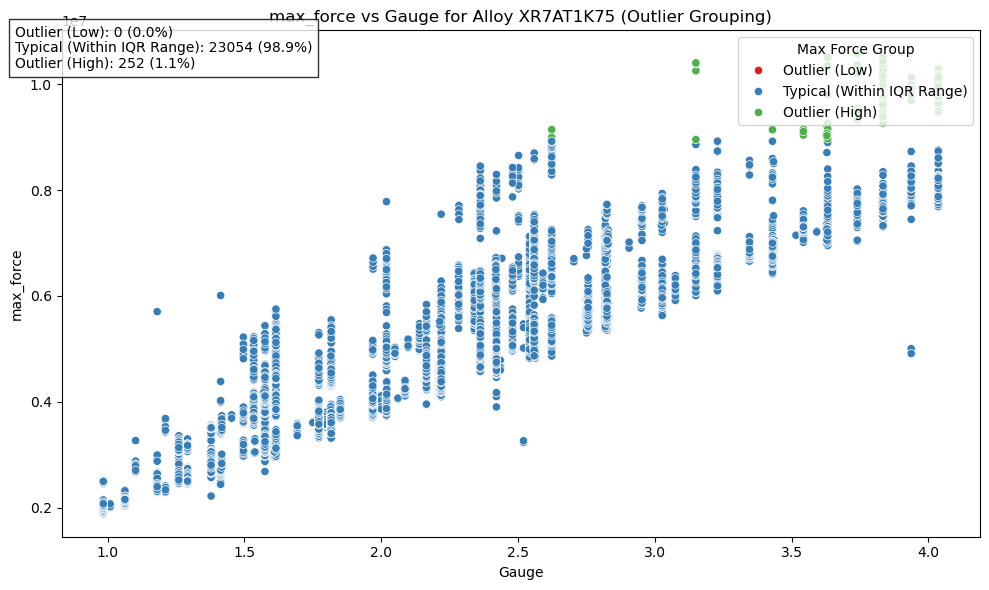

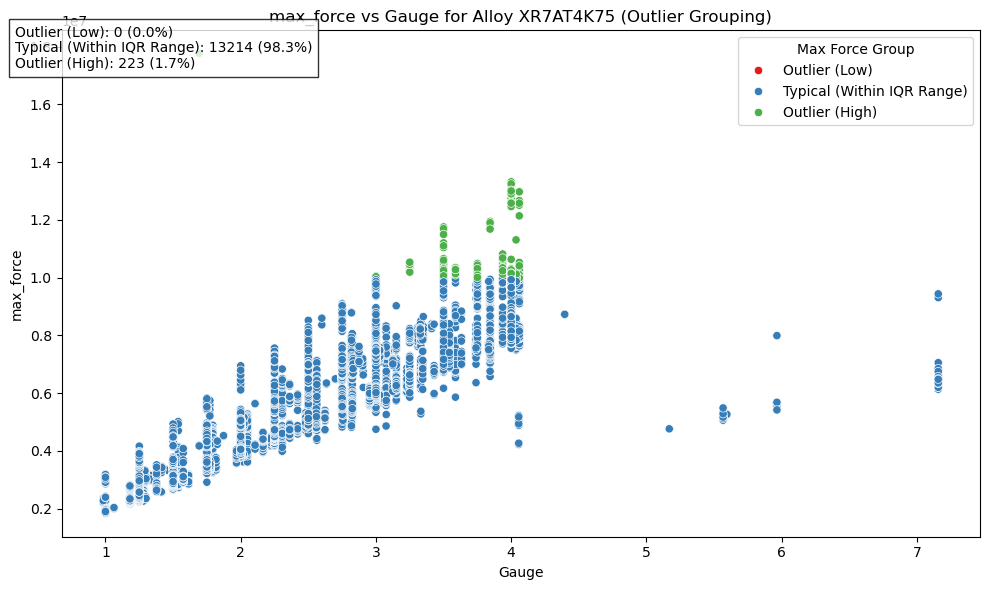

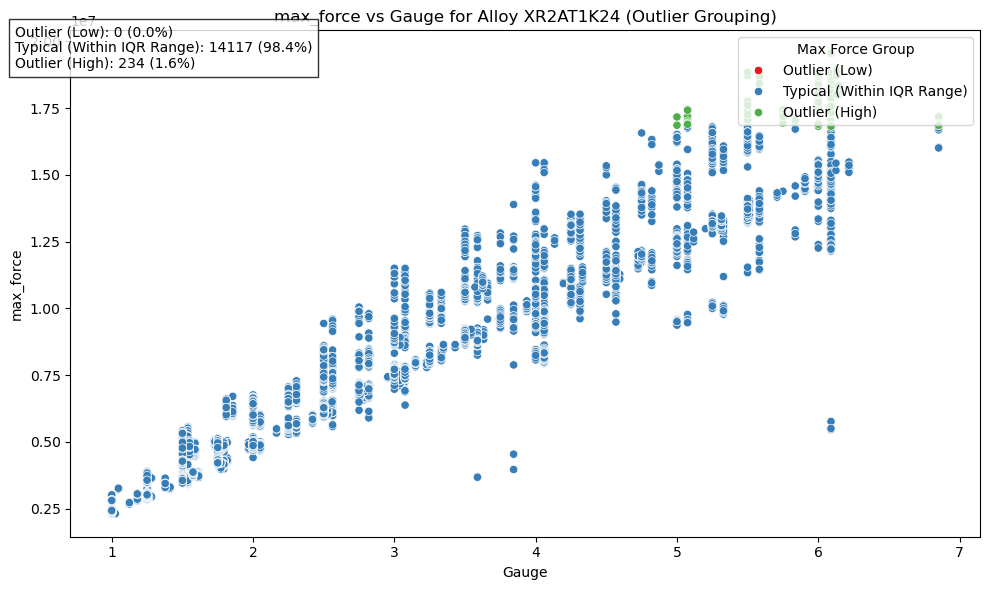

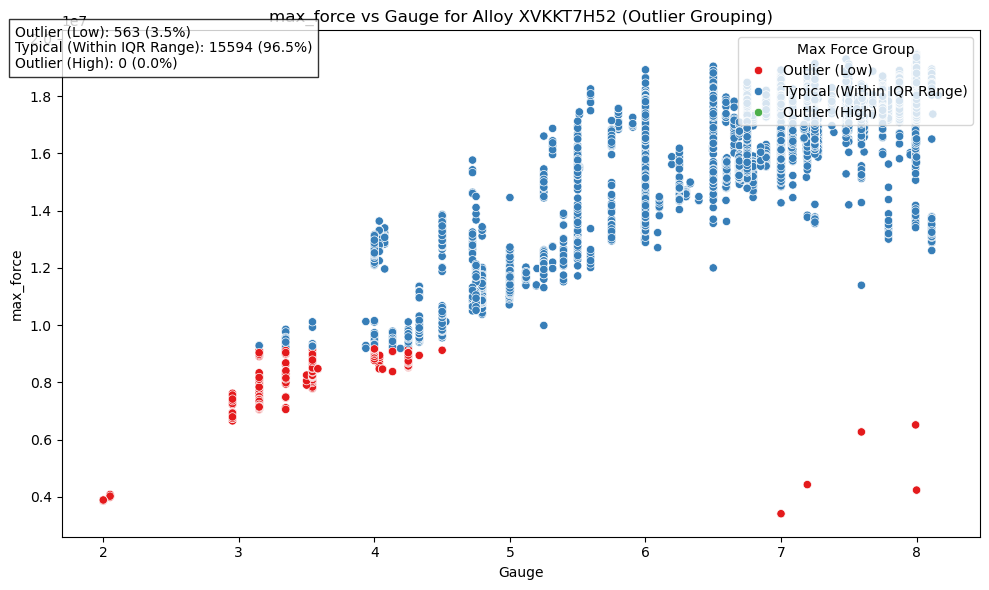

In [46]:
palette = {
    'Outlier (Low)': '#e41a1c',
    'Typical (Within IQR Range)': '#377eb8',
    'Outlier (High)': '#4daf4a'
}
hue_order = ['Outlier (Low)', 'Typical (Within IQR Range)', 'Outlier (High)']

target = 'max_force'
alloy_names = ['XR7AT0K50', 'XR6AT0K61', 'XR7AT0K75', 'XR2AT0K24', 'XR7AT1K75', 'XR7AT4K75', 'XR2AT1K24', 'XVKKT7H52']

for alloy in alloy_names:
    subset = df[df['alloy'] == alloy].copy()

    # IQR and bounds
    q1 = subset[target].quantile(0.25)
    q3 = subset[target].quantile(0.75)
    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    # Categorize values
    def label_force_range(val):
        if val < lower_bound:
            return 'Outlier (Low)'
        elif val > upper_bound:
            return 'Outlier (High)'
        else:
            return 'Typical (Within IQR Range)'
    
    subset['max_force_group'] = subset[target].apply(label_force_range)

    # Count group occurrences
    group_counts = subset['max_force_group'].value_counts().reindex(hue_order, fill_value=0)
    total = len(subset)

    # Format counts and percentages
    count_text = '\n'.join([
        f"{label}: {count} ({count / total:.1%})"
        for label, count in group_counts.items()
    ])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='gauge',
        y=target,
        hue='max_force_group',
        data=subset,
        palette=palette,
        hue_order=hue_order
    )

    # Titles and labels
    plt.title(f'{target} vs Gauge for Alloy {alloy} (Outlier Grouping)')
    plt.xlabel('Gauge')
    plt.ylabel(target)
    plt.legend(title='Max Force Group', loc='upper right')

    # Add annotation box with counts and percentages
    plt.gcf().text(
        0.02, 0.95, count_text,
        fontsize=10, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    plt.tight_layout()
    plt.show()


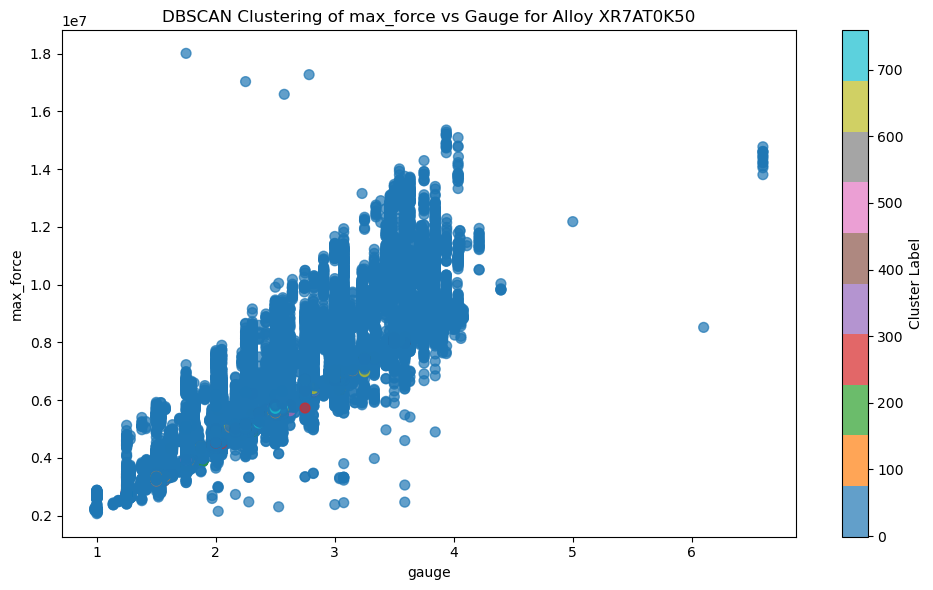

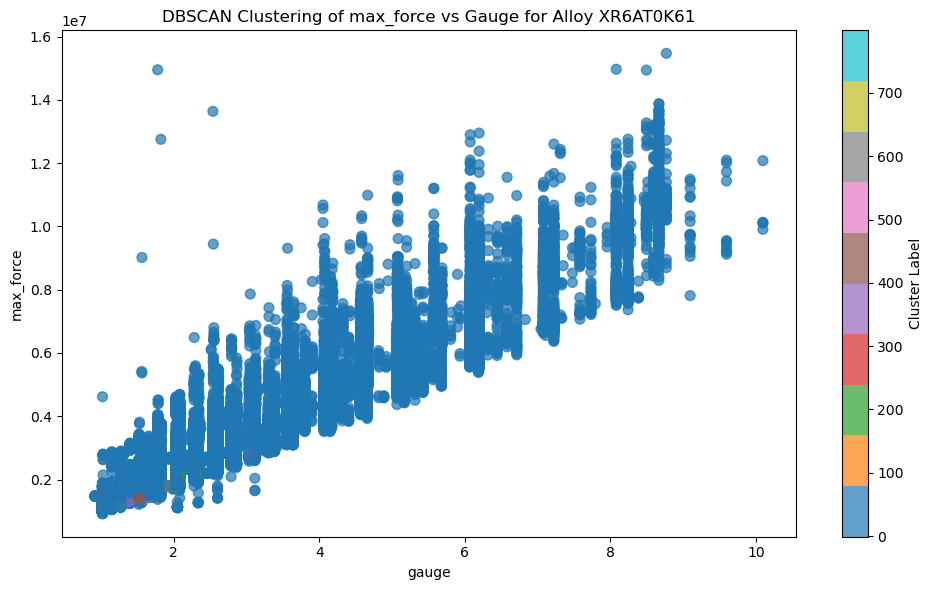

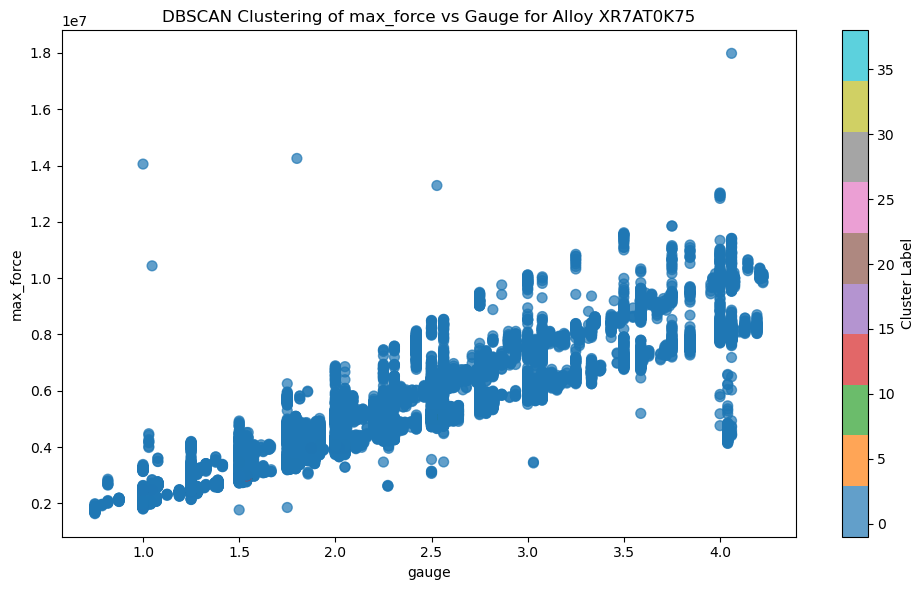

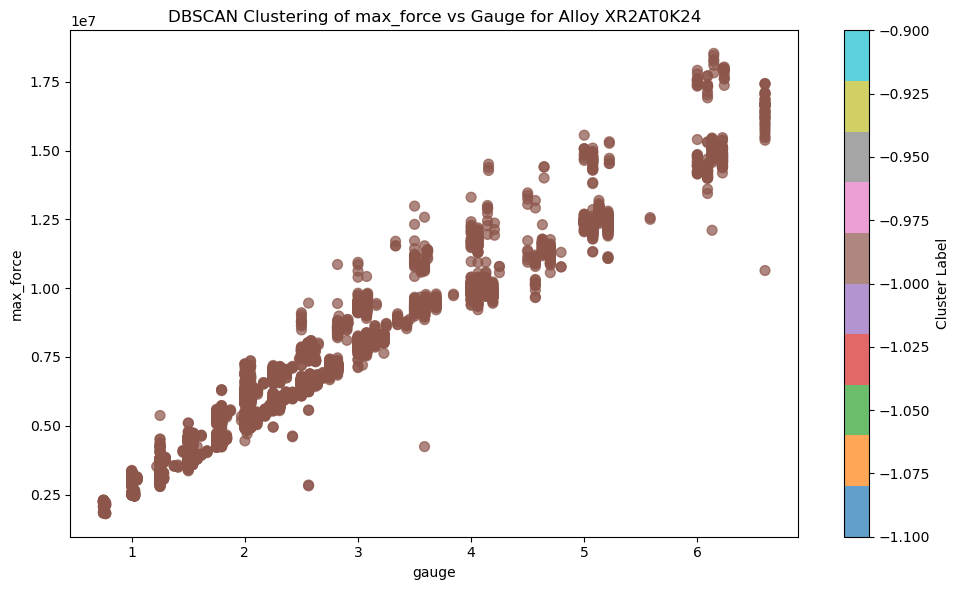

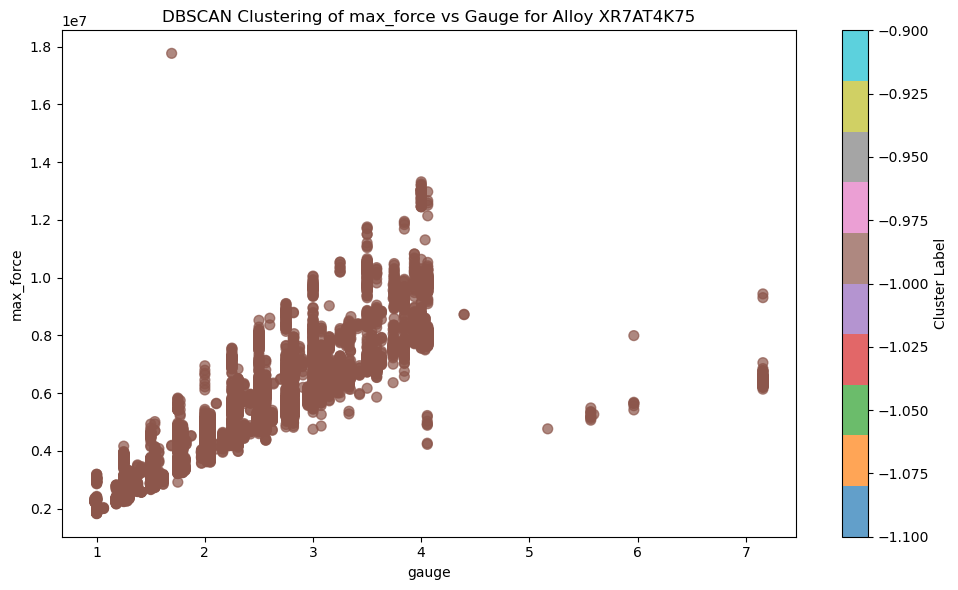

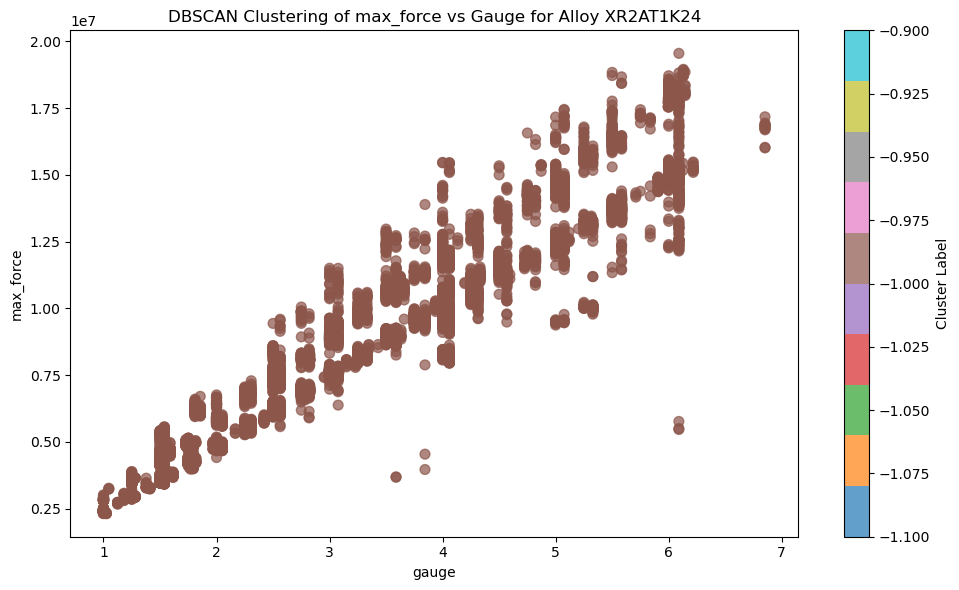

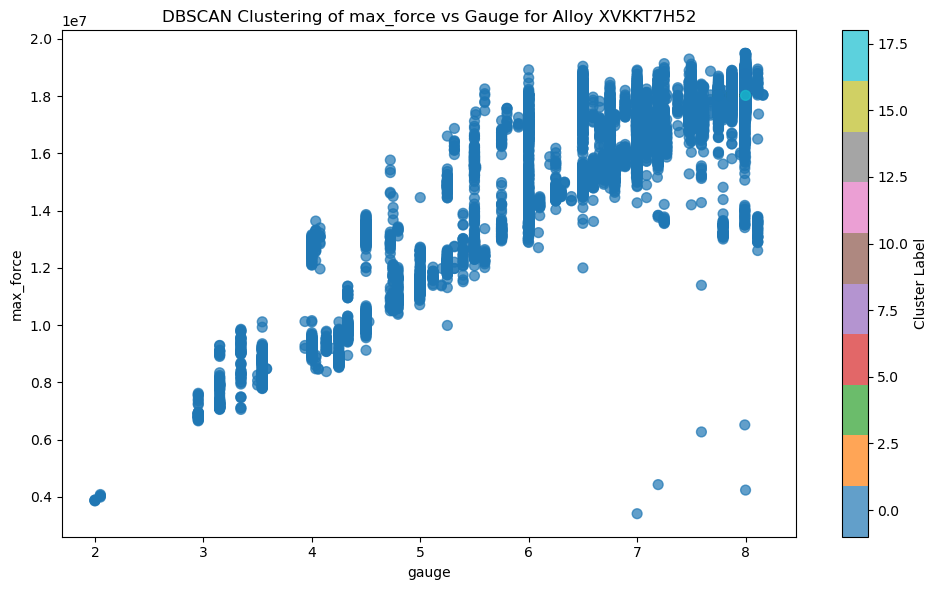

In [19]:
for alloy in alloy_names:
    subset = df[df['alloy'] == alloy]
    X = subset[['gauge', target]].values
    
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(X)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='tab10', s=50, alpha=0.7)
    plt.title(f'DBSCAN Clustering of {target} vs Gauge for Alloy {alloy}')
    plt.xlabel('gauge')
    plt.ylabel(target)
    plt.colorbar(scatter, label='Cluster Label')
    plt.tight_layout()
    plt.show()


In [20]:
df['max_force_mlbs'] = df['max_force'] / 1_000_000

df.groupby('alloy')['max_force_mlbs'].agg(['mean', 'std', 'count']).sort_values('count', ascending=False)



mean       std   count
alloy                                 
XR7AT0K50   6.324208  1.830599  129049
XVKKT7H51   9.191407  3.470432  100595
XR6AT0K61   3.143675  1.870593   83880
XR7AT0K75   4.867762  1.707086   47400
XR7AT1K75   4.778021  1.570058   23306
XVKKT7H55  15.200714  2.991705   16570
XVKKT7H52  15.873254  2.845752   16157
XR2AT1K24   8.117913  3.518997   14351
XR7AT4K75   5.527144  1.844928   13437
XR2AT0K24   6.294698  2.769901    9600
XVKKT6H69   8.009400  2.853377    8581
XVKKT2H12  11.985774  4.548249    7773
XVKKT6H61   2.154786  0.502641    6554
XR2AT2K19   5.864425  2.816138    3629
XVKKT7H77  12.647678  1.974931    2184
XVKKT2H14  14.945659  2.832064    1165
XVKKT7H71   2.525310  0.064590     807
XVKKT7H90   7.779687  2.512751     609
XR6AT1K01   1.195404  0.219768     321
XR2AT0K14   4.338879  0.288889     186
XVKKT7H80  11.659027  4.012559     124
XVKKT7H91   4.050065  1.979757      64
XR7AT0K17   3.777393  1.633793      20
XVKKT2H81   6.194433  2.985896      17
XVKKT2H71   4.697426  1.586536       9
XR2AT0K50   6.889676  3.009385       5

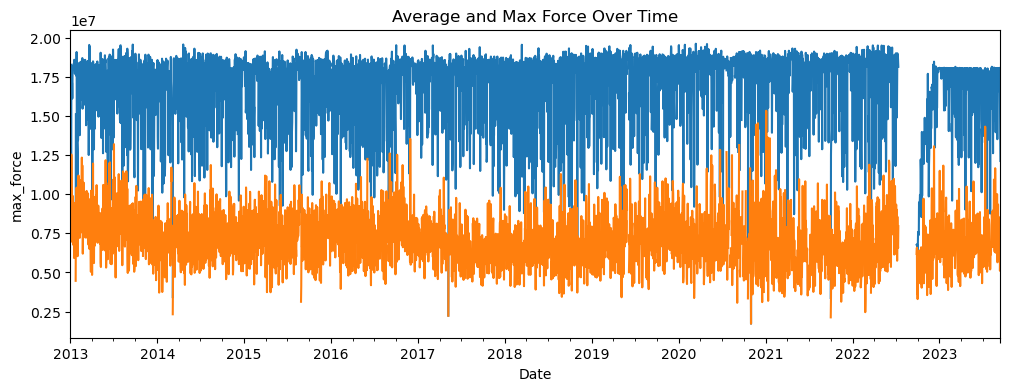

In [21]:
plt.figure(figsize=(12, 4))
df.set_index('discharge')['max_force'].resample('D').max().plot()
df.set_index('discharge')['max_force'].resample('D').mean().plot()
plt.title('Average and Max Force Over Time')
plt.ylabel('max_force')
plt.xlabel('Date')
plt.show()

Company stated the equipment broken and was under repair mid 2022. Started with small product after rebuild therefore maximums are lower than 2022.

Summary:

The stronger predictor for max_force is the gauge or thickness of the product material. There are linear relationships between these that can be used for future product predictions. Binning by the stretch_target further refines the equation and filtering for outliers highlights which points aren't as needed for general predictions.